In [ ]:
""" File for stitching together 2d images (.png) and saving as 3d volumes (.npy) """

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import tqdm

mask_dir="/Volumes/LaCie/sem_dauer_2_gj_gt"
img_dir="/Volumes/LaCie/SEM_dauer_2_em"

In [4]:
# sort the files by z, y, x (ensure that img and mask files are in the same order)
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)
mask_pattern=r"sem_dauer_2_gj_gt_s(\d+).png"
img_pattern=r"SEM_dauer_2_em_s(\d+).png"
img_files = [os.path.join(img_dir, f) for f in img_files if f.endswith(".png")]
mask_files = [os.path.join(mask_dir, f) for f in mask_files if f.endswith(".png")]
print(img_files[:10])
print(mask_files[:10])

['/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s100.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s101.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s102.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s103.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s104.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s105.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s106.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s107.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s108.png', '/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s109.png']
['/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s100.png', '/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s101.png', '/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s102.png', '/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s103.png', '/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s104.png', '/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s105.png', '/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_g

In [5]:
import models
import utilities

# --- reload the modules
import importlib
importlib.reload(models)
importlib.reload(utilities)
# --- end of reload

from models import *
from utilities import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_name = "model_job84"
epoch=49
fp=f"/Volumes/LaCie/models/{model_name}_epoch_{epoch}.pth"
# fp=f"/Users/huayinluo/Documents/code/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
# fp=f"/home/huayin/Documents/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
model, optimizer, epoch, loss, batch_size, lr, focal_loss_weights = load_checkpoint(model, optimizer, fp)
model = model.eval()

In [6]:
# masks:
z_indices = [101, 102, 103, 104, 105, 106, 107, 108, 109]
# z_indices = [101, 102, 103]
# width = 9360
# height = 8328
width = 512
height = 512
depth = len(z_indices) 
old_height = 9360
new_height = 256 # new height of each tile
old_width = 8328
new_width = 256 # new height of each tile
stride = 512 // 4
print(f"stride:{stride}")
print(f"num new imgs: {old_height // stride}")

stride:128
num new imgs: 73


In [7]:
def get_z(file_name, pattern):
    """ get z from file name (uses basename of file_name)"""
    file_name = os.path.basename(file_name)
    match = re.match(pattern, file_name)
    if match:
        z = match.groups()[0]
        return int(z)
    else:
        return None
def get_img_by_z(z, img_files, img_pattern):
    """ get path of image by z, y, x """
    for i in range(len(img_files)):
        img_file = img_files[i]
        try:
            z_ = get_z(img_file, img_pattern)
        except:
            continue
        if z == z_:
            return cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    return None

def get_3d_slice_by_z(z, img_files, img_pattern, depth_padding=1, width=512, height=512):
    img_3d = np.zeros((2*depth_padding+1, width, height))
    for i in range(-depth_padding, depth_padding+1):
        z_coord = z+i
        img = get_img_by_z(z_coord, img_files, img_pattern)
        if img is not None:
            img_3d[i+depth_padding] = img
    return img_3d

SEM_dauer_2_em_s(\d+).png sem_dauer_2_gj_gt_s(\d+).png
102


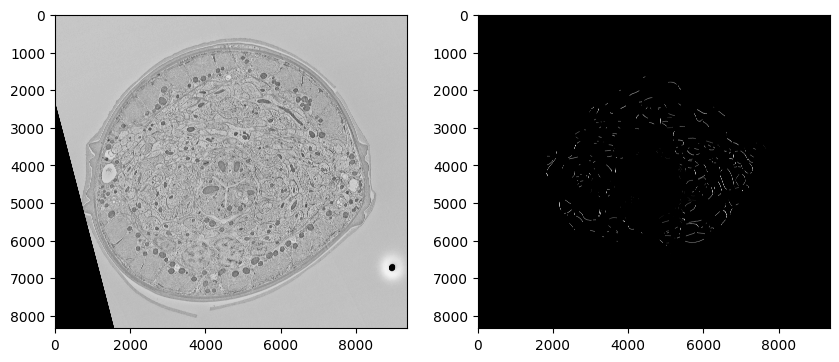

In [8]:
# sanity check: test that image and mask actually match
num = 2
print(img_pattern, mask_pattern)
z = get_z(img_files[num].split('/')[-1], img_pattern)
print(z)
tmp_img = get_img_by_z(z, img_files, img_pattern)
tmp_mask = get_img_by_z(z, mask_files, mask_pattern)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(tmp_img, cmap='gray')
ax[1].imshow(tmp_mask, cmap='gray')

In [10]:
start_y = 0
start_x = 0
start_z = 100
ending_depth = 111
ending_height = 8328
ending_width = 9360

full_volume_img = np.zeros((ending_depth-start_z, ending_height-start_y, ending_width-start_x))
full_volume_mask = np.zeros((ending_depth-start_z, ending_height-start_y, ending_width-start_x))
i=0
for z in range(start_z, ending_depth):
    tmp_img = get_img_by_z(z, img_files, img_pattern)
    tmp_mask = get_img_by_z(z, mask_files, mask_pattern)
    full_volume_img[i] = tmp_img
    full_volume_mask[i] = tmp_mask
    i+=1
    print(f"done {z}")

done 100
done 101
done 102
done 103
done 104
done 105
done 106
done 107
done 108
done 109
done 110


In [11]:
print(full_volume_img.shape)

(11, 8328, 9360)


In [ ]:
np.save("/Volumes/LaCie/100_110_img.npy", full_volume_img)
np.save("/Volumes/LaCie/100_110_mask.npy", full_volume_mask)

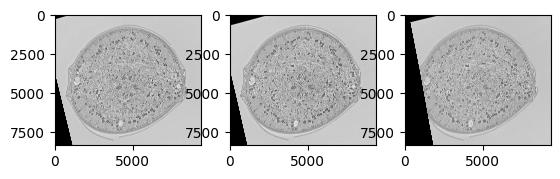

In [12]:
from utilities import *
fig, ax = plt.subplots(1,3)
visualize_3d_slice(full_volume_img[5:8,:, :], ax)

In [39]:
save_dir = "/Volumes/LaCie/dauer_10_slices_tmp"
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, "original"))
    os.makedirs(os.path.join(save_dir, "ground_truth"))
    os.makedirs(os.path.join(save_dir, "pred"))
    os.makedirs(os.path.join(save_dir, "visualize"))

In [41]:
import torchio as tio
import torch

start_z = 0
start_y = 0
start_x = 0
ending_depth = full_volume_img.shape[0]
ending_height = full_volume_img.shape[1]
ending_width = full_volume_img.shape[2]
print(ending_depth, ending_height, ending_width)
subvol_depth = 3
subvol_height = 256
subvol_width = 256

while start_z < ending_depth:
    end_z = start_z + subvol_depth
    while start_y < ending_height:
        end_y = start_y + subvol_height 
        while start_x < ending_width:
            end_x = start_x + subvol_width
            sub_volume_img = full_volume_img[start_z:end_z, start_y:end_y, start_x:end_x]
            sub_volume_mask = full_volume_mask[start_z:end_z, start_y:end_y, start_x:end_x]
            sub_vol_depth, sub_vol_height, sub_vol_width = sub_volume_img.shape
            image = torch.tensor(sub_volume_img).float().unsqueeze(0)
            if (sub_vol_height < subvol_height) or (sub_vol_width < subvol_width) or (sub_vol_depth < subvol_depth):
                image = tio.CropOrPad((subvol_depth, subvol_height, subvol_width))(image)
            image = tio.ZNormalization()(image)
            print(image.shape)
            intermed_pred, sub_volume_pred = model(image)
            binary_pred = torch.argmax(sub_volume_pred[0], dim=0) # (depth, height, width)
            np.save(os.path.join(save_dir, "original", f"z{start_z}_y{start_y}_x{start_x}.npy"), sub_volume_img)
            np.save(os.path.join(save_dir, "ground_truth", f"z{start_z}_y{start_y}_x{start_x}.npy"), sub_volume_mask)
            np.save(os.path.join(save_dir, "pred", f"z{start_z}_y{start_y}_x{start_x}.npy"), sub_volume_pred.detach().cpu())            
            fig, ax = plt.subplots(3, subvol_depth, figsize=(15,5), num=1)
            visualize_3d_slice(sub_volume_img, ax[0], "Image")
            visualize_3d_slice(sub_volume_mask, ax[1], "Mask")
            visualize_3d_slice(binary_pred, ax[2], "Pred")
            print(f"Saved z{start_z}-{end_z} y{start_y}-{end_y} x{start_x}-{end_x} subvolume")
            plt.savefig(os.path.join(save_dir, "visualize", f"z{start_z}_y{start_y}_x{start_x}.png"))
            plt.close("all")
            start_x = end_x
        start_y = end_y
    start_z = end_z

3 8328 9360
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x0-256 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x256-512 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x512-768 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x768-1024 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x1024-1280 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x1280-1536 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x1536-1792 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x1792-2048 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x2048-2304 subvolume
torch.Size([1, 3, 256, 256])
Saved z0-3 y0-256 x2304-2560 subvolume
torch.Size([1, 3, 256, 256])


KeyboardInterrupt: 

(1, 2, 3, 32, 32)


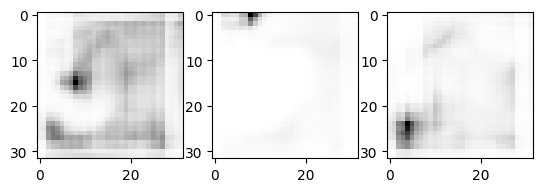

In [34]:
from utilities import *
results = np.load(os.path.join(save_dir, "pred", f"z0_y0_x0.npy"))
print(results.shape)
fig, ax = plt.subplots(1,3)
visualize_3d_slice(results[0,0], ax)

(3, 512, 512) (3, 512, 512) (3, 512, 512)
(6, 512, 512) (6, 512, 512)


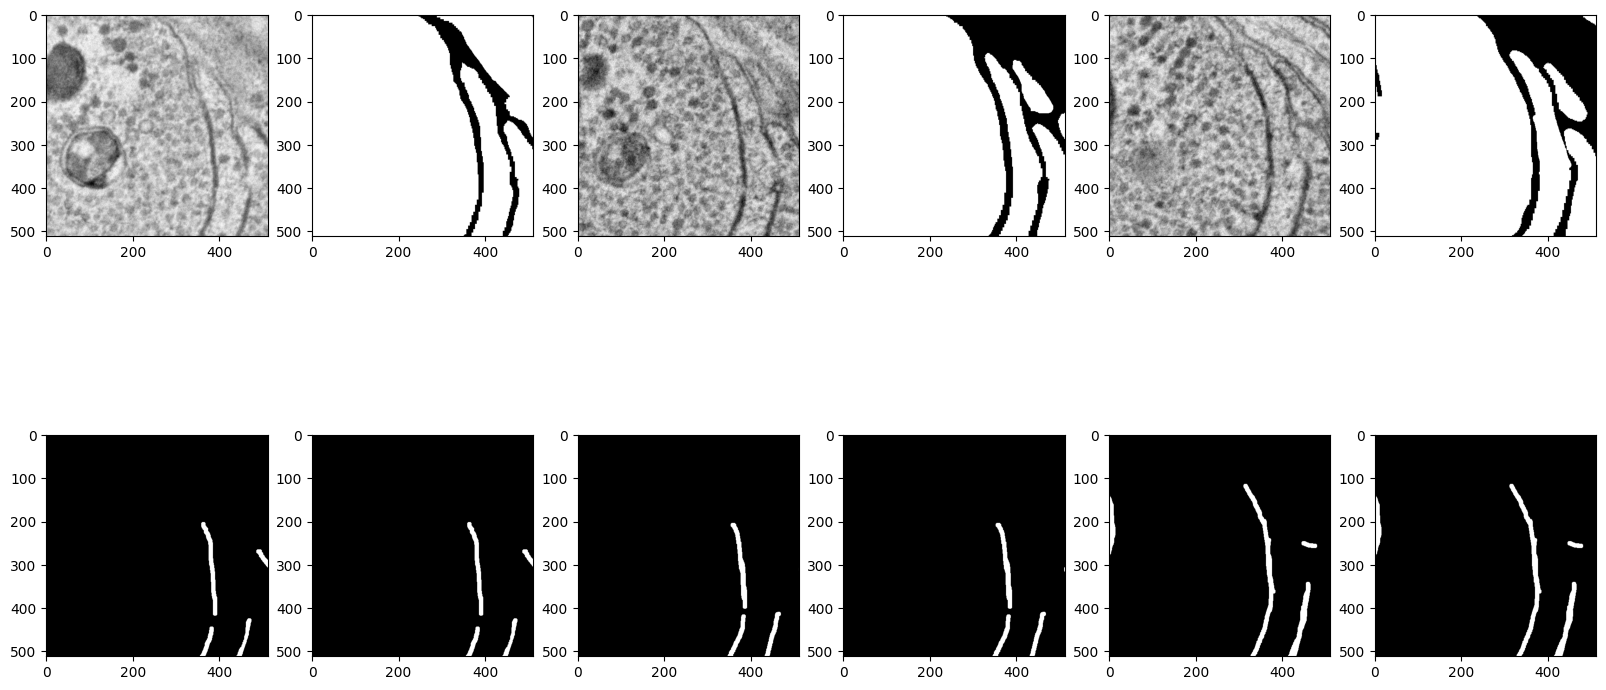

In [57]:
depth=1
alternate=True
if alternate:
    combined_img_3d = np.repeat(img_3d, 2, axis=0)
    for i in range(3):
        combined_img_3d[2*i+1] = filtered_cell_mask_3d[i]
    combined_mask_3d = np.repeat(mask_3d, 2, axis=0)
else:
    combined_img_3d = np.concatenate((img_3d, filtered_cell_mask_3d), axis=0)
    combined_mask_3d = np.concatenate((mask_3d, mask_3d), axis=0)
print(img_3d.shape, mask_3d.shape, cell_mask_3d.shape)
print(combined_img_3d.shape, combined_mask_3d.shape)
depth=2*(2*depth+1)
fig, ax = plt.subplots(2, depth, figsize=(20, 10))
for i in range(depth):
    ax[0, i].imshow(combined_img_3d[i], cmap='gray')
    ax[1, i].imshow(combined_mask_3d[i], cmap='gray')
plt.show()
# depth=2*depth+1
# fig, ax = plt.subplots(4, depth, figsize=(20, 10))
# for i in range(depth):
#     ax[0, i].imshow(img_3d[i], cmap='gray')
#     ax[1, i].imshow(mask_3d[i], cmap='gray')
#     ax[2, i].imshow(cell_mask_3d[i], cmap='gray')
#     ax[3, i].imshow(filtered_cell_mask_3d[i], cmap='gray')
#     ax[0, i].set_title(f"img slice {i}")
# plt.show()

In [59]:
print(len(img_files), len(mask_files))

5390 5390


In [58]:
save_dir = "/Volumes/LaCie/membrane_alternate_select_data_512"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(os.path.join(save_dir, "original")):
    os.makedirs(os.path.join(save_dir, "original"))
if not os.path.exists(os.path.join(save_dir, "ground_truth")):
    os.makedirs(os.path.join(save_dir, "ground_truth"))

In [65]:
# save 3d slices
depth = 1 # (5, 512, 512)
total = len(img_files)
# total=2
alternate=True
for i in range(total):
    print(f"saved {i}/{total}", end="\r")
    try:
        z, y, x = get_z_y_x(img_files[i], img_pattern)
    except:
        continue
    try:
        img_3d = get_3d_slice_single_img(z, y, x, img_files, img_pattern, depth=depth)
        mask_3d = get_3d_slice_single_img(z, y, x, mask_files, mask_pattern, depth=depth)
        cell_mask_3d = get_3d_slice_single_img(z, y, x, cell_mask_files, cell_mask_pattern, depth=depth)
        filtered_cell_mask_3d = cell_mask_3d.copy()
        filtered_cell_mask_3d[filtered_cell_mask_3d!=0]=1
        if alternate:
            combined_img_3d = np.repeat(img_3d, 2, axis=0)
            for i in range(2*depth + 1):
                combined_img_3d[2*i+1] = filtered_cell_mask_3d[i]
            combined_mask_3d = np.repeat(mask_3d, 2, axis=0)
        else:
            combined_img_3d = np.concatenate((img_3d, filtered_cell_mask_3d), axis=0)
            combined_mask_3d = np.concatenate((mask_3d, mask_3d), axis=0)
    except:
        print(f"no 3d slice available for {z}{y}{x}")
        continue
    img_3d = img_3d.astype(np.uint8)
    mask_3d = mask_3d.astype(np.uint8)
    filtered_cell_mask_3d = filtered_cell_mask_3d.astype(np.uint8)
    if i == 0:
        print(img_3d.shape, mask_3d.shape)
        print(combined_img_3d.shape, combined_mask_3d.shape)
    np.save(os.path.join(save_dir, "original", f"z{z}_y{y}_x{x}.npy"), combined_img_3d)
    np.save(os.path.join(save_dir, "ground_truth", f"z{z}_y{y}_x{x}.npy"), combined_mask_3d)

(6, 512, 512)


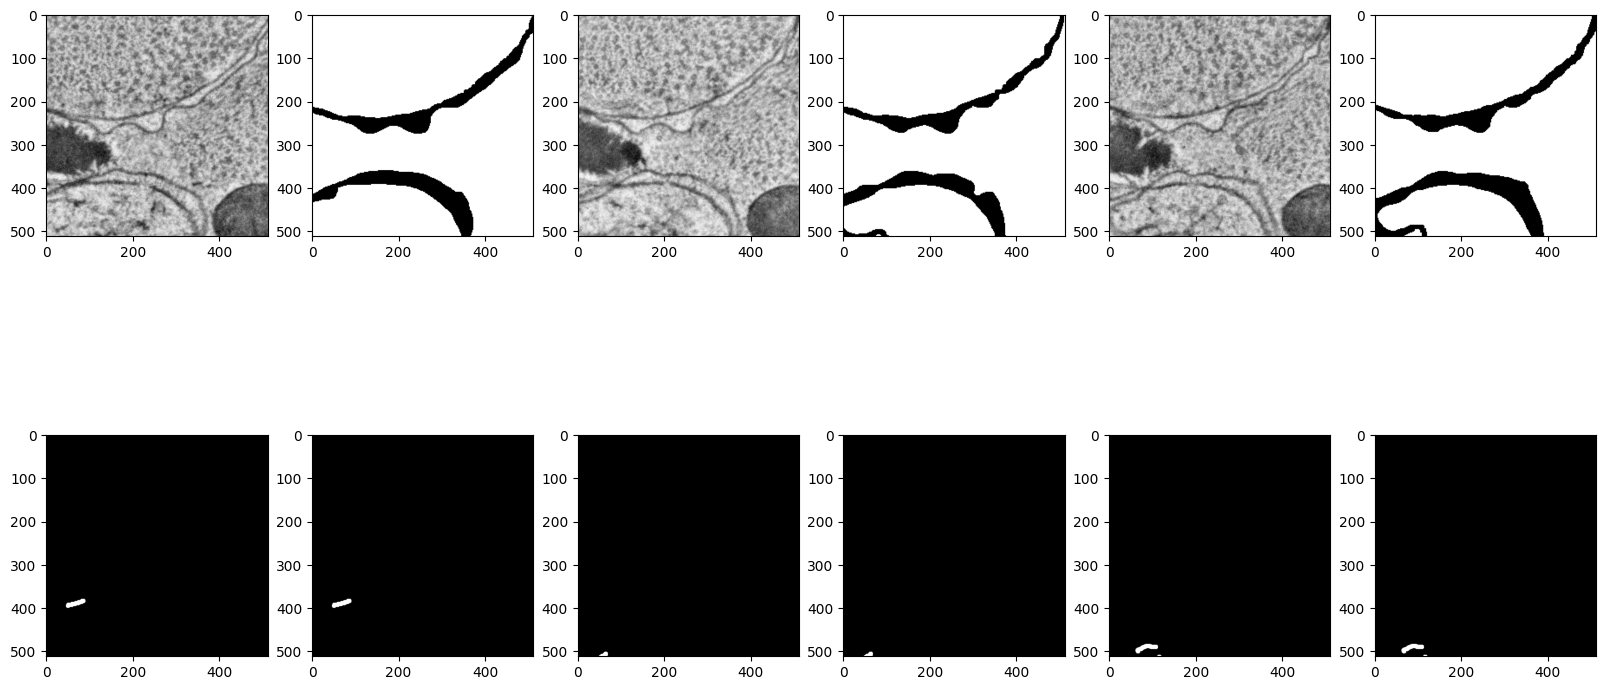

In [66]:
# sanity check
tmp = np.load(os.path.join(save_dir, "original", f"z{z}_y{y}_x{x}.npy"))
print(tmp.shape)
depth=6
fig, ax = plt.subplots(2, depth, figsize=(20, 10))
for i in range(depth):
    ax[0, i].imshow(combined_img_3d[i], cmap='gray')
    ax[1, i].imshow(combined_mask_3d[i], cmap='gray')
plt.show()

In [64]:
files = os.listdir(os.path.join(save_dir, "original"))
print(len(files)) # 243 training samples (some may overlap a bit, fine for now)

1


# Train Test Split

In [76]:
# data_dir = "data/small_data_512" # CHANGE ME
data_dir = "/Volumes/LaCie/dauer_data_512"

# load data
img_dir = os.path.join(data_dir, "original")
mask_dir = os.path.join(data_dir, "ground_truth")
img_paths = os.listdir(img_dir)
mask_paths = os.listdir(mask_dir)
imgs = [np.load(os.path.join(img_dir, img_path)) for img_path in img_paths if img_path.endswith(".npy")]
masks = [np.load(os.path.join(mask_dir, mask_path)) for mask_path in mask_paths if mask_path.endswith(".npy")]

In [77]:
# create subdirectories for train, valid, test
if not os.path.exists(os.path.join(img_dir, "train")):
    os.makedirs(os.path.join(img_dir, "train"))
if not os.path.exists(os.path.join(img_dir, "valid")):
    os.makedirs(os.path.join(img_dir, "valid"))
if not os.path.exists(os.path.join(img_dir, "test")):
    os.makedirs(os.path.join(img_dir, "test"))   
if not os.path.exists(os.path.join(mask_dir, "train")):
    os.makedirs(os.path.join(mask_dir, "train"))
if not os.path.exists(os.path.join(mask_dir, "valid")):
    os.makedirs(os.path.join(mask_dir, "valid"))
if not os.path.exists(os.path.join(mask_dir, "test")):
    os.makedirs(os.path.join(mask_dir, "test"))

In [79]:
# split data into train, valid, test
num_imgs = len(imgs)
indices = np.arange(num_imgs)
np.random.shuffle(indices)
train_indices = indices[:int(0.8*num_imgs)]
valid_indices = indices[int(0.8*num_imgs):int(0.9*num_imgs)]
test_indices = indices[int(0.9*num_imgs):]
print(len(train_indices), len(valid_indices), len(test_indices))
imgs = np.array(imgs)
masks = np.array(masks)
print("imgs shape: ", imgs.shape)

2156 269 270
imgs shape:  (2695, 3, 512, 512)


In [80]:
train_imgs = imgs[train_indices]
valid_imgs = imgs[valid_indices]
test_imgs = imgs[test_indices]

train_masks = masks[train_indices]
valid_masks = masks[valid_indices]
test_masks = masks[test_indices]
print(f"Train: {train_masks.shape}, {train_imgs.shape}") # (num_imgs, 512, 512, 3)
print(f"Valid: {valid_masks.shape}, {valid_imgs.shape}")
print(f"Test: {test_masks.shape}, {test_imgs.shape}")

Train: (2156, 3, 512, 512), (2156, 3, 512, 512)
Valid: (269, 3, 512, 512), (269, 3, 512, 512)
Test: (270, 3, 512, 512), (270, 3, 512, 512)


In [ ]:
# save imgs
for i,img in tqdm.tqdm(enumerate(train_imgs)):
    np.save(os.path.join(img_dir, "train", f"{i}.npy"), train_imgs[i])
    print(f"Saved train {i}")
for i,img in tqdm.tqdm(enumerate(valid_imgs)):
    np.save(os.path.join(img_dir, "valid", f"{i}.npy"), valid_imgs[i])
    print(f"Saved valid {i}")
for i,img in tqdm.tqdm(enumerate(test_imgs)):
    np.save(os.path.join(img_dir, "test", f"{i}.npy"), test_imgs[i])
    print(f"Saved test {i}")

# save masks
for i,mask in tqdm.tqdm(enumerate(train_masks)):
    np.save(os.path.join(mask_dir, "train", f"{i}.npy"), train_masks[i])
    print(f"Saved train {i}")
for i,mask in tqdm.tqdm(enumerate(valid_masks)):
    np.save(os.path.join(mask_dir, "valid", f"{i}.npy"), valid_masks[i])
    print(f"Saved valid {i}")
for i,mask in tqdm.tqdm(enumerate(test_masks)):
    np.save(os.path.join(mask_dir, "test", f"{i}.npy"), test_masks[i])
    print(f"Saved test {i}")

print("Done")

# Slice Data (smaller images)

In [1]:
""" Section one 512 x 512 image into sixteen 128 x 128 tiles."""

' Section one 512 x 512 image into sixteen 128 x 128 tiles.'

In [2]:
import os

old_dir = "/Volumes/LaCie/select_dauer_data_512"
new_dir = "/Volumes/LaCie/filtered_dauer_data_256"

# directory with the original images (full size)
old_img_dir = os.path.join(old_dir, "original")
old_mask_dir = os.path.join(old_dir, "ground_truth")
# directory to save the new images (small size)
new_img_dir = os.path.join(new_dir, "original")
new_mask_dir = os.path.join(new_dir, "ground_truth")

In [36]:
# Create new directories as needed
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
if not os.path.exists(new_img_dir):
    os.makedirs(new_img_dir)
if not os.path.exists(new_img_dir + "/train"):
    os.makedirs(new_img_dir + "/train")
if not os.path.exists(new_img_dir + "/valid"):
    os.makedirs(new_img_dir + "/valid")
if not os.path.exists(new_mask_dir):
    os.makedirs(new_mask_dir)
if not os.path.exists(new_mask_dir + "/train"):
    os.makedirs(new_mask_dir + "/train")
if not os.path.exists(new_mask_dir + "/valid"):
    os.makedirs(new_mask_dir + "/valid")

In [8]:
img_paths_train = os.listdir(old_img_dir + "/train")
mask_paths_train = os.listdir(old_mask_dir + "/train")
img_paths_valid = os.listdir(old_img_dir + "/test")
mask_paths_valid = os.listdir(old_mask_dir + "/test")
print(len(img_paths_train), len(mask_paths_train), len(img_paths_valid), len(mask_paths_valid))

old_height = 512

# CHANGE ME
new_height = 256 # new height of each tile
# stride = 512 // new_height # stride to move the window
stride = 512 // 4
print(f"stride:{stride}")
print(f"num new imgs: {old_height // stride}")

2048 2048 512 512
stride:128
num new imgs: 4


In [4]:
# sanity check
import numpy as np

k = 2
fp = img_paths_train[k]
img = np.load(old_img_dir + "/train/" + fp)
mask = np.load(old_mask_dir + "/train/" + fp)

# split the image into tiles
for i in range(0, old_height, stride):
    if i + new_height > old_height:
        break
    for j in range(0, old_height, stride):
        if j+new_height > old_height:
            break
        img_tile = img[:, i:i+new_height, j:j+new_height]
        mask_tile = mask[:, i:i+new_height, j:j+new_height]
        print("img_tile shape", img_tile.shape)
        print("mask_tile shape", mask_tile.shape)
        # filter out black boxes
        num_unique = len(np.unique(mask_tile))
        print(f"width {i}:{i+new_height}, height {j}:{j+new_height}, {num_unique}")
        if num_unique < 2:
            continue
        print("saved")


img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 0:256, height 0:256, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 0:256, height 128:384, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 0:256, height 256:512, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 128:384, height 0:256, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 128:384, height 128:384, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 128:384, height 256:512, 1
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 256:512, height 0:256, 1
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 256:512, height 128:384, 1
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 256:512, height 256:512, 1


In [38]:
import numpy as np
import tqdm

# train set
counter = 0 # for naming the new files
num_imgs = len(img_paths_train)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_train[k]
    img = np.load(old_img_dir + "/train/" + fp)
    mask = np.load(old_mask_dir + "/train/" + fp)
    
    # split the image into tiles
    for i in range(0, old_height, stride):
        if i+new_height >= old_height:
            break
        for j in range(0, old_height, stride):
            if j+new_height >= old_height:
                break
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            
            # filter out black boxes
            num_unique = len(np.unique(mask_tile))
            if num_unique < 2:
                continue
            np.save(new_img_dir + "/train/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/train/" + str(counter) + ".npy", mask_tile)
            counter += 1

  2%|▏         | 31/2048 [00:03<04:12,  7.98it/s]


KeyboardInterrupt: 

In [7]:
print(len(img_paths_valid))

0


In [10]:
import tqdm
# train set
counter = 0 # for naming the new files
num_imgs = len(img_paths_valid)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_valid[k]
    img = np.load(old_img_dir + "/test/" + fp)
    mask = np.load(old_mask_dir + "/test/" + fp)
    
    # split the image into tiles
    for i in range(0, old_height, stride):
        if i+new_height >= old_height:
            break
        for j in range(0, old_height, stride):
            if j+new_height >= old_height:
                break
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            
            # filter out black boxes
            num_unique = len(np.unique(mask_tile))
            if num_unique < 2:
                continue
            np.save(new_img_dir + "/valid/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/valid/" + str(counter) + ".npy", mask_tile)
            counter += 1

100%|██████████| 512/512 [01:08<00:00,  7.52it/s]
